In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My \Drive/Colab \Notebooks/Optimal \Transport/Repository


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from torch.autograd import Variable

import wandb
import os

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output

from PIL import Image
from torchvision import models

from tqdm.notebook import tqdm as tqdm
import ot

from networks import resnet_d, conv_icnn32, unet, dense_icnn, conv_icnn64
from networks.resnet_d import weights_init_D

from torch.utils.data import DataLoader, Subset

#from losses import VGGPerceptualLoss

from utils import fig2data, fig2img, plot_images

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [4]:
IMG_SIZE = 64 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CHANNELS = 3

TRANSFORM = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load train datasets
dataset_combined = datasets.ImageFolder('datasets/shoes_handbags_64_OT', transform=TRANSFORM)

BATCH_SIZE = 733

dataset_shoes = Subset(dataset_combined, range(733, len(dataset_combined)))
dataset_handbags = Subset(dataset_combined, range(0, 733))

assert len(dataset_shoes) == len(dataset_handbags)

shoes_loader = DataLoader(dataset_shoes, batch_size=BATCH_SIZE, shuffle=False)
handbags_loader = DataLoader(dataset_handbags, batch_size=BATCH_SIZE, shuffle=False)

X = next(iter(shoes_loader))[0]
Y = next(iter(handbags_loader))[0]

del shoes_loader, handbags_loader

print('X: ', X.shape)
print('Y: ', Y.shape)




X:  torch.Size([733, 3, 64, 64])
Y:  torch.Size([733, 3, 64, 64])


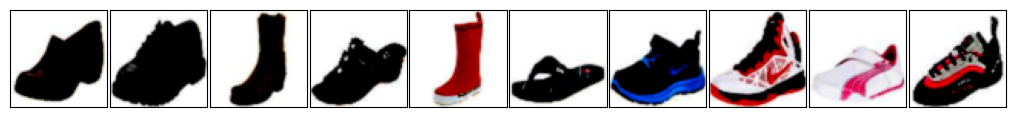

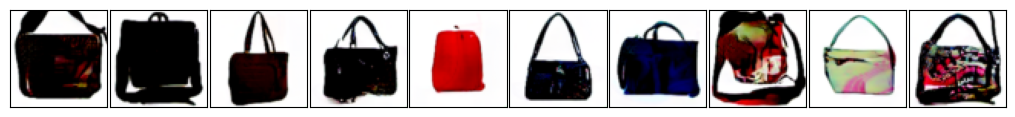

In [6]:
plot_images(X, cmap='RGB')
plot_images(Y, cmap='RGB');

torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])
OT pairing is correct


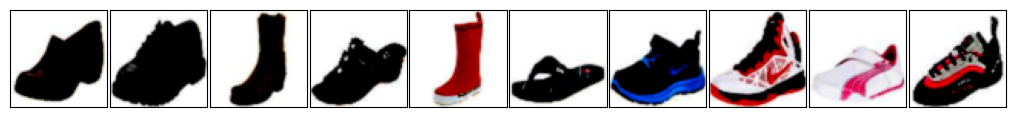

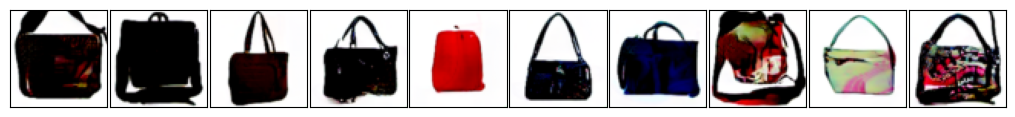

In [10]:

Xs = X.reshape(-1, CHANNELS * IMG_SIZE**2)
Xt = Y.reshape(-1, CHANNELS * IMG_SIZE**2)

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs[:], Xt=Xt[:])

transp_Xt_emd = ot_emd.transform(Xs=Xs)
test_idx = 162


image_original = np.transpose(Xs[test_idx].reshape(CHANNELS, IMG_SIZE, IMG_SIZE), (1,2,0))
image_transformed = np.transpose(transp_Xt_emd[test_idx].reshape(CHANNELS, IMG_SIZE, IMG_SIZE), (1,2,0))

PAIRS_TO_PICK = 10

X_test_paired = X[:].reshape(-1, 3, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
Y_test_paired = transp_Xt_emd.reshape(-1, 3, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
plot_images(X_test_paired, cmap='RGB')
plot_images(Y_test_paired, cmap='RGB')

print(X_test_paired.shape)
print(Y_test_paired.shape)

found_pairs = torch.argmax(ot_emd.coupling_, dim=1).numpy()

optimal_pairs = np.array([i for i in range(733)])
assert found_pairs.all() == optimal_pairs.all()

print('OT pairing is correct')

## ConvICNN

In [22]:
def train_conv(model_dict, X_train, Y_train, X_test, Y_test, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT):
    
    model_name = list(model_dict.keys())[0]
    phi = model_dict[model_name]

    try:
        for epoch in range(EPOCHS):

            permutation = torch.randperm(X_train.size()[0])

            for i in range(0, X_train.size()[0], BATCH_SIZE_LOOP):

                indices = permutation[i:i+BATCH_SIZE_LOOP]
                image_x, image_y = X_train[indices].to(DEVICE), Y_train[indices].to(DEVICE)
                
                if model_name == 'resnet_d':
                    out = phi(image_x).squeeze(1)
                else:
                    out = phi(image_x).squeeze()

                if model_name != 'unet':
                    out = torch.autograd.grad(out, image_x, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(image_x.size()[0]).cuda().float())[0]

                loss = criterion(out, image_y)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                if CONVEXIFY:
                    phi.convexify()

            if epoch % EPOCH_REPORT == 0:

                clear_output(wait=True)
                print(f'Epoch: {epoch}/{EPOCHS}')
                wandb.log({"loss": loss.item()}, step=epoch)
                print('| Training loss: ', loss.item())

                if model_name == 'resnet_d':
                    out = phi(X_test).squeeze(1)
                else:
                    out = phi(X_test).squeeze()

                if model_name != 'unet':
                    out = torch.autograd.grad(out, X_test, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(X_test.size()[0]).cuda().float())[0]

                fig1 = plot_images(X_test.cpu().detach(), 10, cmap=cmap)
                fig2 = plot_images(out.cpu().detach(), 10, cmap=cmap)
                plot_images(Y_test.cpu().detach(), 10, cmap=cmap)
                wandb.log({'Images' : [wandb.Image(fig2img(fig1)), wandb.Image(fig2img(fig2))]}, step=epoch) 

                plt.show()
                
    except KeyboardInterrupt:
        print('Interrupting by keyboard, returning trained model...')
        return phi

    return phi

In [18]:
model_name = 'conv_icnn64'
CONVEXIFY = True
loss_name = 'l1_loss'

#losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss, 'percep': VGGPerceptualLoss(DEVICE=DEVICE)}
losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss}

if model_name == 'unet':
    phi = unet.UNet(CHANNELS, 3)
if model_name == 'resnet_d':
    phi = resnet_d.ResNet_D(size=IMG_SIZE)
    phi.apply(weights_init_D)
if model_name == 'conv_icnn64':
    phi = conv_icnn64.ConvICNN64(CHANNELS)

phi.to(DEVICE)

criterion = losses[loss_name]

LR = 1e-3
optimizer = torch.optim.Adam(phi.parameters(), lr=LR, betas=(0.8, 0.99))

Epoch: 900/1000
| Training loss:  2.1915249824523926


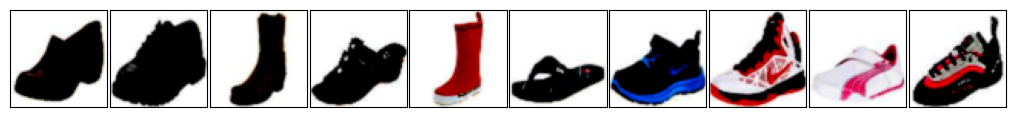

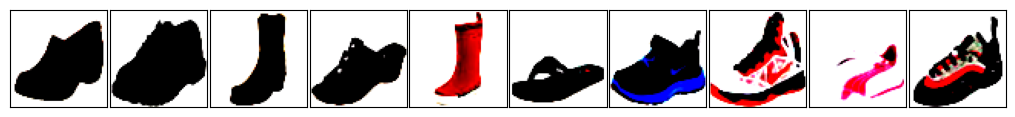

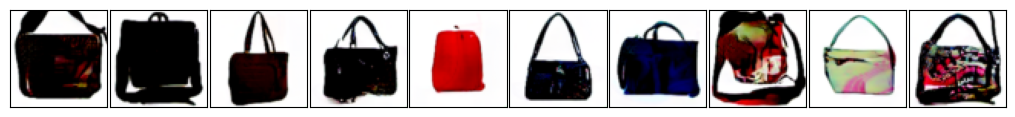

In [23]:
# treat the network as a discriminator that will check if two images are pairs or not.

os.environ["WANDB_API_KEY"] = '449eb3fa3ebc473bba15c04ccfd03a676c074f00'
#os.environ["WANDB_MODE"] = "online"

cmap = "RGB"
EPOCHS = 1000

BATCH_SIZE_LOOP = 64
PAIRS_TO_PICK = 10
EPOCH_REPORT = 100

N_TRAIN = PAIRS_TO_PICK

config = {
  "dataset": "BenchMarkDataset",
  "machine": "Colab",
  "model": model_name,
  "loss_function": loss_name,
  "image_size": IMG_SIZE,
  "learning_rate": LR,
  "batch_size_loop": BATCH_SIZE_LOOP,
  "batch_size_paired": PAIRS_TO_PICK,
  "epochs": EPOCHS
}

if model_name == 'conv_icnn64':
  wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"BenchMarkDataset-{model_name}-{CONVEXIFY}-{loss_name}", entity="icnn-23", config=config)
else:
  wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"BenchMarkDataset-{model_name}-{loss_name}", entity="icnn-23", config=config)

X_paired = X[:].reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
Y_paired = transp_Xt_emd[:].reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]

X_train = Variable(X_paired[:N_TRAIN], requires_grad=True)
Y_train = Variable(Y_paired[:N_TRAIN], requires_grad=True)

X_test = X_train[:10].to(DEVICE).requires_grad_(True)
Y_test = Y_train[:10].to(DEVICE).requires_grad_(True)

assert X_train.shape == (N_TRAIN, 3, IMG_SIZE, IMG_SIZE)

del X_paired, Y_paired

model_dict = {model_name:phi}

phi_trained = train_conv(model_dict, X_train, Y_train, X_test, Y_test, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT)


        

## DenseICNN

In [29]:
def train_dense(model, X, Y, X_test, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT):
    
    phi = model

    try:
        for epoch in range(EPOCHS):

            permutation = torch.randperm(X.size()[0])

            for i in range(0, X.size()[0], BATCH_SIZE_LOOP):

                indices = permutation[i:i+BATCH_SIZE_LOOP]
                image_x, image_y = X[indices].to(DEVICE), Y[indices].to(DEVICE)
                
                out = phi(image_x).squeeze()

                out = torch.autograd.grad(out, image_x, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(image_x.size()[0]).cuda().float())[0]

                loss = criterion(out, image_y)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                if CONVEXIFY:
                    phi.convexify()

            if epoch % EPOCH_REPORT == 0:

                clear_output(wait=True)
                print(f'Epoch: {epoch}/{EPOCHS}')
                wandb.log({"loss": loss.item()}, step=epoch)
                print('| Training loss: ', loss.item())

                out = phi(X_test).squeeze(1)
                out = torch.autograd.grad(out, X_test, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(X_test.size()[0]).cuda().float())[0]

                fig1 = plot_images(X_test.reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE).cpu().detach(), 10, cmap=cmap)
                fig2 = plot_images(out.reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE).cpu().detach(), 10, cmap=cmap)
                wandb.log({'Images' : [wandb.Image(fig2img(fig1)), wandb.Image(fig2img(fig2))]}, step=epoch) 

                plt.show()
                
    except KeyboardInterrupt:
        print('Interrupting by keyboard, returning trained model...')
        return phi

    return phi

In [30]:
model_name = 'dense_icnn'
CONVEXIFY = False
loss_name = 'l1_loss'

#losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss, 'percep': VGGPerceptualLoss(DEVICE=DEVICE)}
losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss}

criterion = losses[loss_name]

phi = dense_icnn.DenseICNN(IMG_SIZE**2*CHANNELS).to(DEVICE)

phi.to(DEVICE)
LR = 1e-3
optimizer = torch.optim.Adam(phi.parameters(), lr=LR, betas=(0.8, 0.99))

Epoch: 2850/3000
| Training loss:  0.5435320734977722


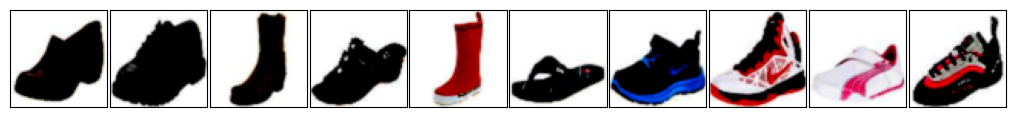

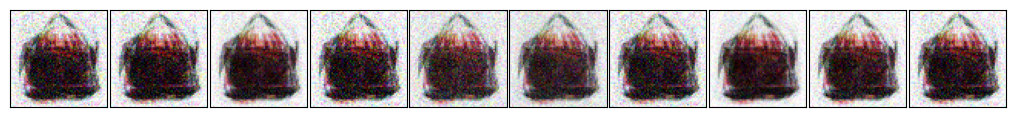

Interrupting by keyboard, returning trained model...


In [31]:
os.environ["WANDB_API_KEY"] = '449eb3fa3ebc473bba15c04ccfd03a676c074f00'
#os.environ["WANDB_MODE"] = "online"

cmap = 'RGB'

EPOCHS = 3000

BATCH_SIZE_LOOP = 64
PAIRS_TO_PICK = 10
EPOCH_REPORT = 50

N_TRAIN = PAIRS_TO_PICK

config = {
  "dataset": "BenchMarkDataset",
  "machine": "Colab",
  "model": model_name,
  "loss_function": loss_name,
  "image_size": IMG_SIZE,
  "learning_rate": LR,
  "batch_size_loop": BATCH_SIZE_LOOP,
  "batch_size_paired": PAIRS_TO_PICK,
  "epochs": EPOCHS
}

wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"Denchmarkdataset-Dense_ICNN-Convexify={CONVEXIFY}-abs-{loss_name}", entity="icnn-23", config=config)

X_paired = X[:].reshape(-1, CHANNELS*IMG_SIZE*IMG_SIZE)[:PAIRS_TO_PICK]
Y_paired = transp_Xt_emd[:].reshape(-1, CHANNELS*IMG_SIZE*IMG_SIZE)[:PAIRS_TO_PICK]

X_train = Variable(X_paired[:N_TRAIN], requires_grad=True).to(DEVICE)
Y_train = Variable(Y_paired[:N_TRAIN], requires_grad=True).to(DEVICE)

X_test = X_train[:10].requires_grad_(True)
Y_test = Y_train[:10].requires_grad_(True)

print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (N_TRAIN, CHANNELS* IMG_SIZE* IMG_SIZE)

del X_paired, Y_paired

phi_trained = train_dense(phi, X_train, Y_train, X_test, EPOCHS, BATCH_SIZE_LOOP, EPOCH_REPORT)
